# Visualization and explore the Wildfire data with Matplotlib, Pandas and Seaborn

This notebook will connect to a MySQL DB in the cloud which houses a combined table for wild
fires in the US and weather conditions during each fire. Independent features will be evaluated 
for collerlation and usefulness in a model. The goal of the model is to predict the fire intensity based on the fire features and the weather.

### Getting Started:
#### Importing the libraries 

In [11]:
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

from sqlalchemy import create_engine   #sql engine

import yellowbrick as yb

import pylab as pl
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


import config #database connection variables 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

### Connect to mySQL database in the cloud
Requires config files stored in the same directory as the notebook, contains the connection information 

Save the data to disk for faster access in the future


In [2]:
def read_from_db() : 
    
    # create sqlalchemy engine
    engine = create_engine("mysql+mysqlconnector://{user}:{password}@{host}/{dbname}"
                       .format(user=config.db_user,
                               password=config.db_pass,
                               dbname=config.db_main,
                               host=config.db_host))
    
    #Create Query Statments

    queryFire = """
    SELECT *
    FROM Fire_Intensity_Model_Clean
    LIMIT 20000;
    """

    
    #Execute Queries
    df_fires = pd.read_sql(queryFire, engine)

    #close the database connection
    engine.dispose()
    
    
    df_fires.to_csv('data/fires1.csv', index = False)
    
    

#### Read from to cloud db
Skip if reading from disk

In [3]:
read_from_db()

### Read data from disk previously stored for faster access 

In [31]:
#Read the data from disk for faster access
df_fires = pd.read_csv('data/FireIntensity_Model_June7_Clean.csv').sample(50000)

df_fires.head()

,latitude,longitude,doy,month,year,cluster_reference,fire_region,season,covertype,fuelcode,...,temperature,humidity,precip_intensity,visibility,wind_speed,wind_gust,brightness,fire_intensity,bright_t31,frp
1274027,43.4714,-116.9215,224,8,2015,2015_1123,1,1,2,2,...,83.77,0.15,0.0,9.997000,8.10,15.46,344.8,Severe,307.6,148.2
879688,33.9801,-111.1426,244,9,2011,2011_7934,4,1,3,1180,...,88.70,0.26,0.0,9.997000,5.74,12.20,301.5,Low,282.2,5.1
952792,33.3463,-108.5950,144,5,2012,2012_146,4,0,3,1220,...,71.55,0.10,0.0,9.216293,9.78,21.78,327.4,High,286.5,21.1
456562,29.8908,-84.9036,218,8,2007,2007_3155,2,1,3,1140,...,105.17,0.65,0.0,9.997000,4.07,10.40,500.0,Severe,318.0,1868.1
847973,33.6020,-109.4595,150,5,2011,2011_503,4,0,3,1220,...,58.02,0.20,0.0,9.216293,11.05,24.87,327.5,High,286.4,32.5


### Display the head of data for check.

In [32]:
print(df_fires.columns)

Index(['latitude', 'longitude', 'doy', 'month', 'year', 'cluster_reference',
       'fire_region', 'season', 'covertype', 'fuelcode', 'prefire_fuel',
       'fuel_moisture_class', 'temperature', 'humidity', 'precip_intensity',
       'visibility', 'wind_speed', 'wind_gust', 'brightness', 'fire_intensity',
       'bright_t31', 'frp'],
      dtype='object')


### Analyze the features in the machine learning table

<i> Goal is to predict the fire intensity</i>

In [33]:
#drop columns which are not relevant 

#remove index column if reading from cloud
df_fires = df_fires.drop(columns=['year', 'cluster_reference', 'latitude', 'longitude', 'month', 'covertype', 
                                  'brightness', 'bright_t31', 'frp'])


In [34]:
#show the shape of the data
print (df_fires.shape)

#show the data by fire_intensity 
print(df_fires.groupby('fire_intensity').count())



(50000, 13)
                  doy  fire_region  season  fuelcode  prefire_fuel  \
fire_intensity                                                       
High            12730        12730   12730     12730         12730   
Low             12277        12277   12277     12277         12277   
Medium          12306        12306   12306     12306         12306   
Severe          12687        12687   12687     12687         12687   

                fuel_moisture_class  temperature  humidity  precip_intensity  \
fire_intensity                                                                 
High                          12730        12730     12730             12730   
Low                           12277        12277     12277             12277   
Medium                        12306        12306     12306             12306   
Severe                        12687        12687     12687             12687   

                visibility  wind_speed  wind_gust  
fire_intensity                    

### Visualize home many of each type of dependent variables we have (1-4)

Use seaborn to plot a count histogram. We have 4 separate categories.
1 (not burned), 2 (light), 3(med), 4 (heavy burn)

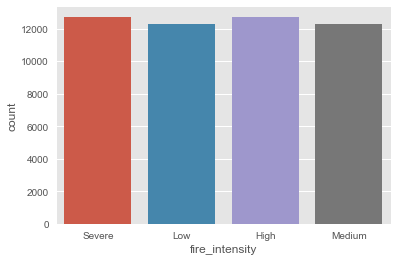

In [35]:
sns.countplot(df_fires['fire_intensity'],label="Count")
plt.show()

### Draw box diagram to see scale and quartiles of data
Data is on a very large scale with could affect some models scaling maybe needed.


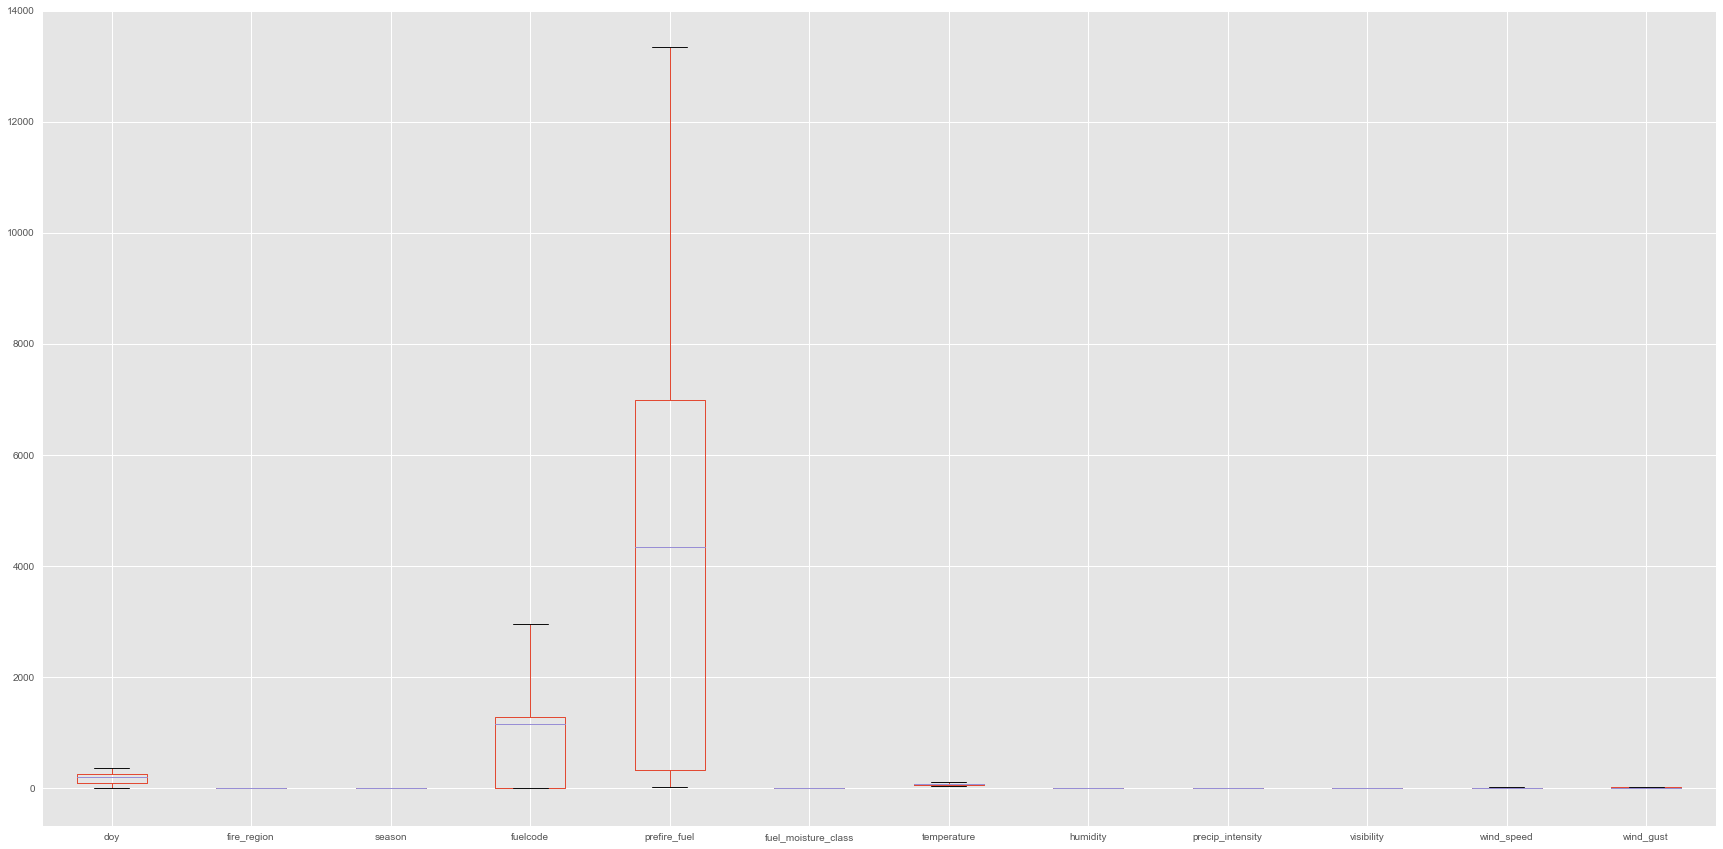

In [36]:
#draw box plot of see range of the data
import matplotlib
matplotlib.style.use('ggplot')
df_fires.plot(kind='box',figsize=(30,15))



### View histogram of all numerical data to better understand the distribution
Graphs show some data is continous while others are categorical. 
No normal distribution shown.Correlations can be seen between ECO/ECO2, EPM2.5/Consumed fuel

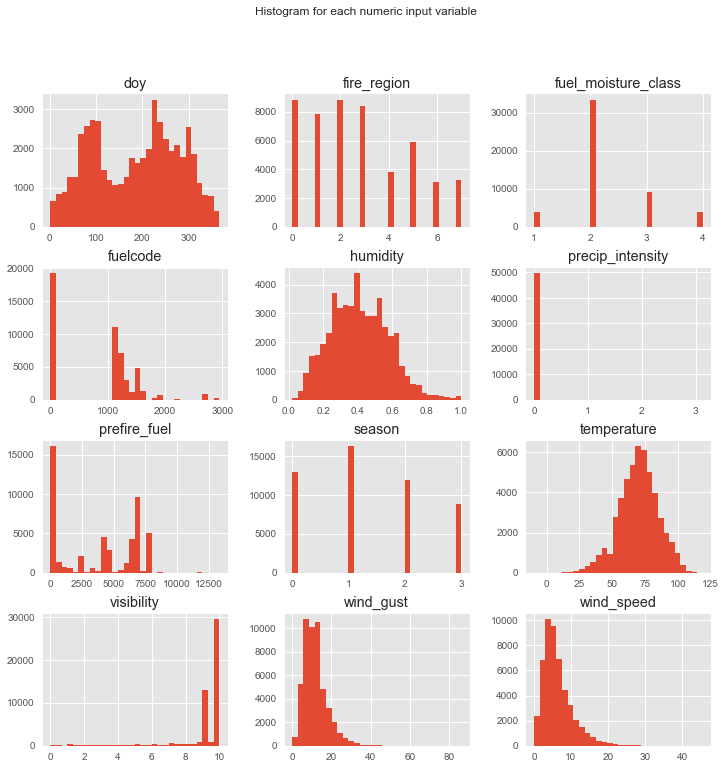

In [37]:
#historgram of all numerical data
df_fires.hist(bins=30, figsize=(12,12))
pl.suptitle("Histogram for each numeric input variable")
plt.show()

In [45]:
print(df_fires.columns)


Index(['latitude', 'longitude', 'doy', 'month', 'fire_region', 'season',
       'covertype', 'fuelcode', 'prefire_fuel', 'fuel_moisture_class',
       'temperature', 'humidity', 'precip_intensity', 'visibility',
       'wind_speed', 'wind_gust', 'brightness', 'fire_intensity', 'bright_t31',
       'frp'],
      dtype='object')


### Scatter matrix plot for the continous values - categorical does not present much value
<i> These features can likely be combined or dropped. Note this take a long time to run (minutes)</i> 

anlaysis says to take out years, month,frp, brightness

#warning takes a long time to run best to skip - not helpful for our data

Text(0.5, 0.98, 'Scatter-matrix for each input variable')

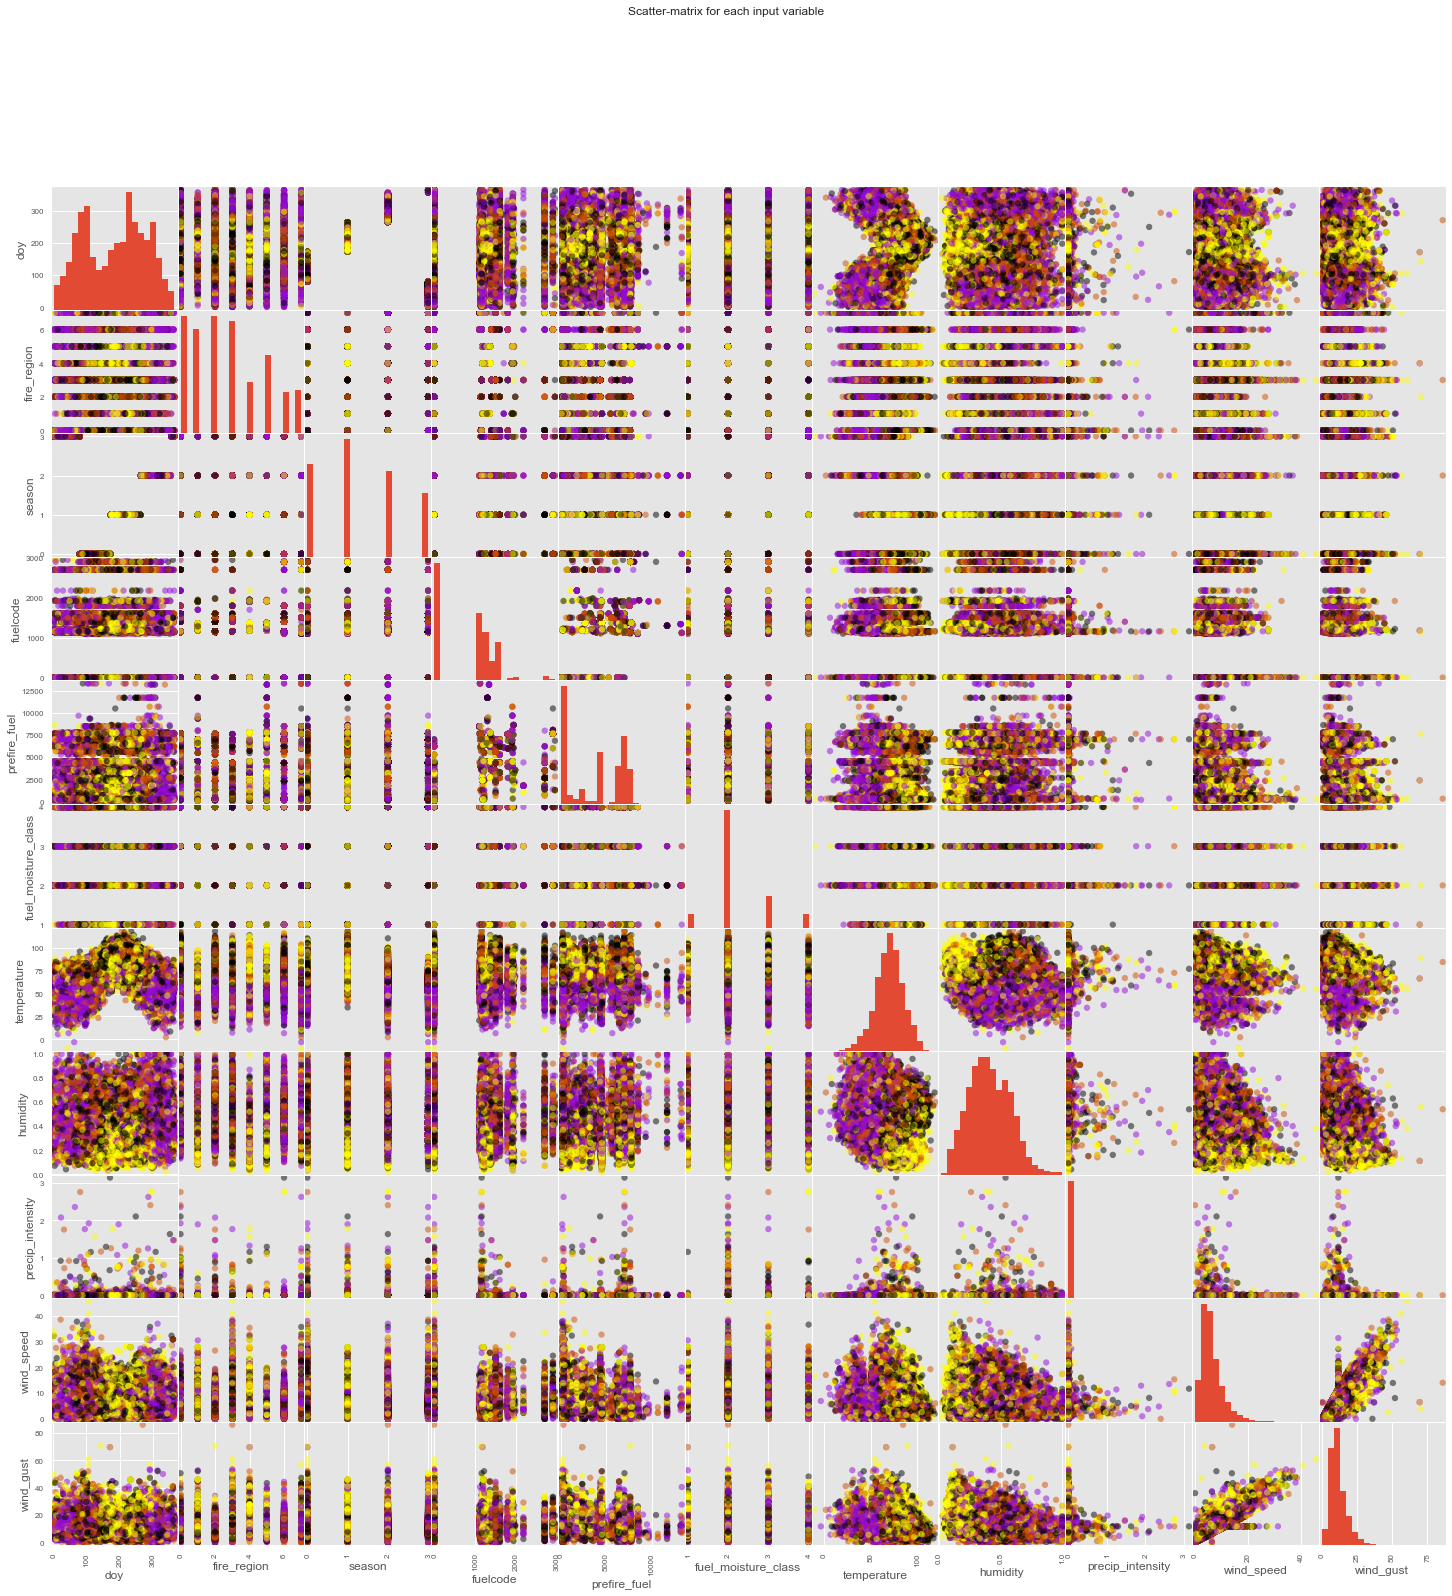

In [39]:
#draw scatter matrix 



#update the feature list if you removed features
feature_names = ['doy', 'fire_region', 'season',
                'fuelcode', 'prefire_fuel', 'fuel_moisture_class',
                'temperature', 'humidity', 'precip_intensity',
                'wind_speed', 'wind_gust']

X = df_fires[feature_names]
y = df_fires['fire_intensity']
y = LabelEncoder().fit_transform(y)

cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(X, c = y, marker = 'o', s=40, hist_kwds={'bins':20}, figsize=(25,25), cmap = cmap)
plt.suptitle('Scatter-matrix for each input variable')


### Show which features likely have the most impact 
<i> RadViz in unclear</i>

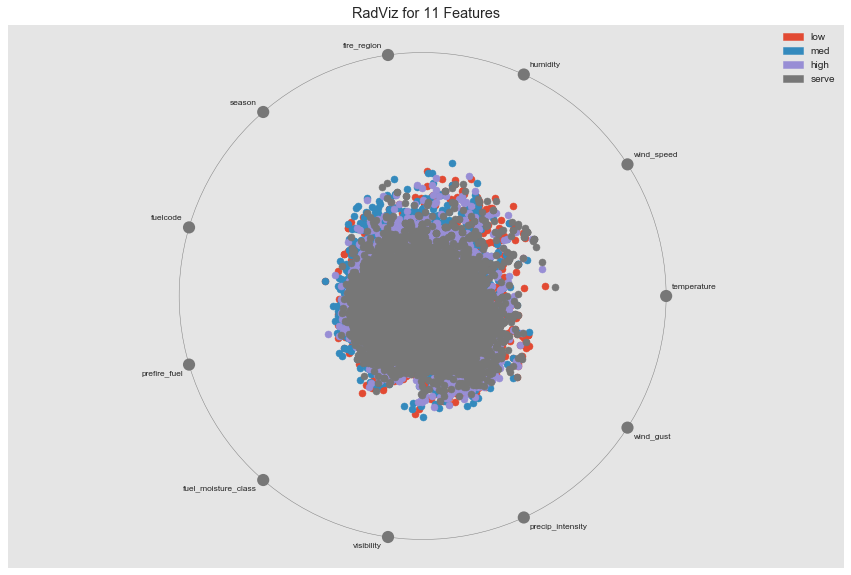

In [40]:
from yellowbrick.features import RadViz

#drop features for simplicity lat/lon/doy/visiblity 
feature_names = [ 'temperature', 'wind_speed','humidity', 'fire_region', 'season', 
                 'fuelcode', 'prefire_fuel', 'fuel_moisture_class',
                 'visibility', 'precip_intensity', 'wind_gust']

X = df_fires[feature_names]
#X = StandardScaler().fit_transform(X)
y = df_fires['fire_intensity']
y = LabelEncoder().fit_transform(y)

# Specify the target classes
classes = ["low", "med", "high", "serve"]

# Instantiate the visualizer
visualizer = RadViz(classes=classes, features=feature_names, size=(1080, 720))

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Draw the data

### Show Random forest classier of the most important features to predict severity

<i>  I get different answers eveytime I run this but a random decision tree? Top and bottom half are consistent though. Run 3-4 times to get a feel </i>

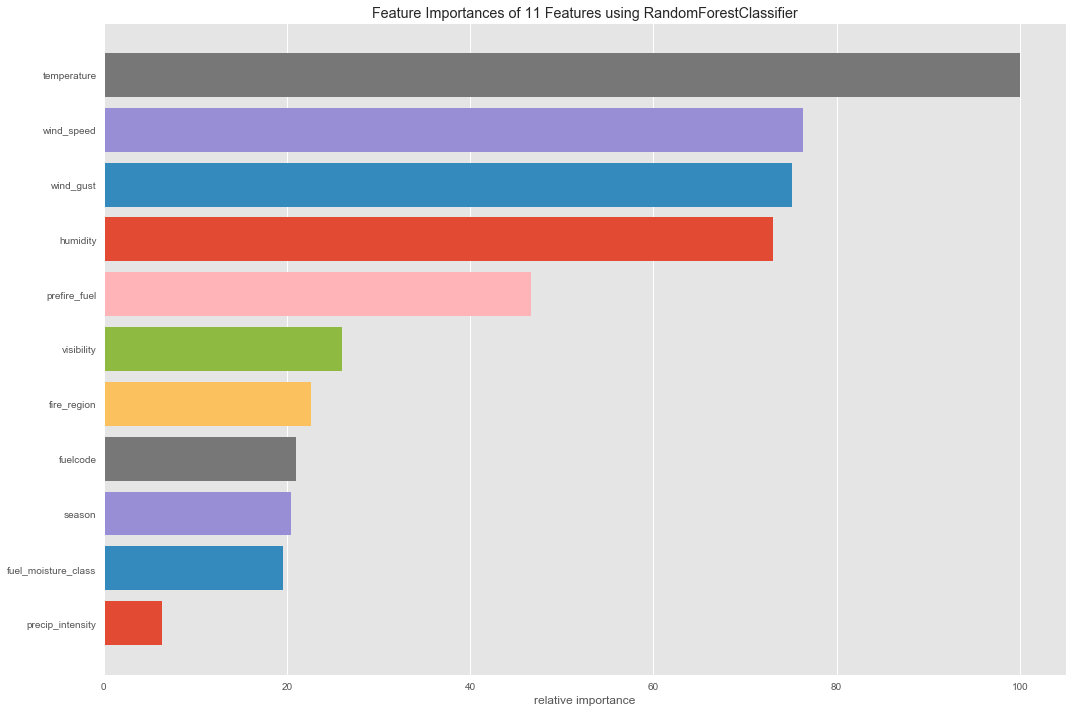

In [41]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=20)
viz = FeatureImportances(model, labels=feature_names, size=(1080, 720))

viz.fit(X, y)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.show()

### Visualize using rank 2D
<i> This shows a high digree of multicollinearity. Columsn can likely be combined or dropped </i>

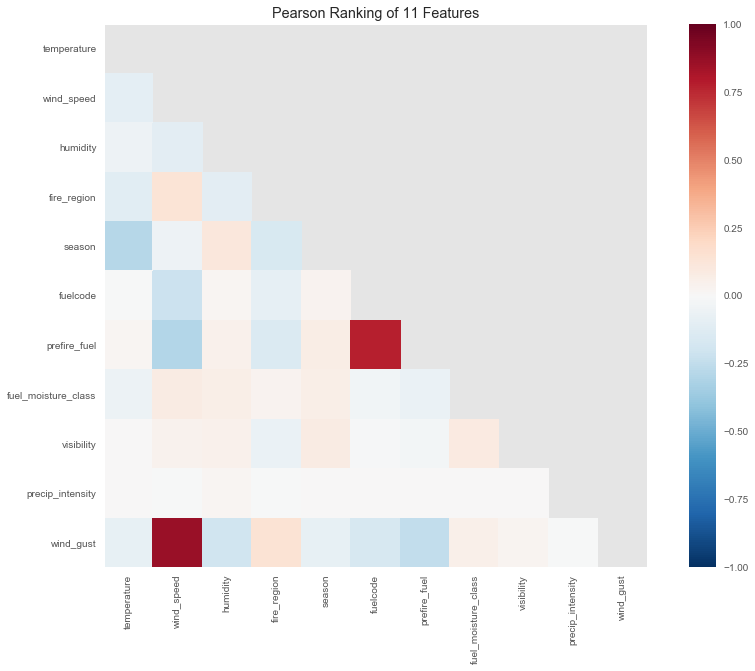

In [42]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', features=feature_names, size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

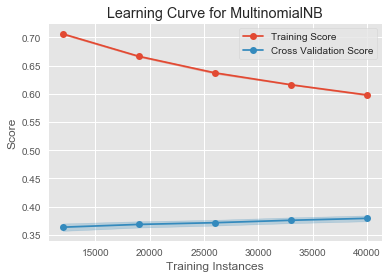

In [45]:
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB


from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve

# Load a classification dataset
#X, y = load_game()

# Encode the categorical data
X = df_fires[feature_names]
y = df_fires['fire_intensity']
y = LabelEncoder().fit_transform(y)
X = OneHotEncoder(categories="auto").fit_transform(X)
#X = StandardScaler().fit_transform(X) 

#X is throwing an error as negative  need to check

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 5)

# Instantiate the classification model and visualizer
model = MultinomialNB()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

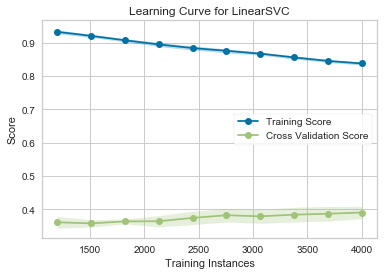

In [19]:
# Instantiate the classification model and visualizer
#Only run if you have time

"""
model = LinearSVC()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

"""





/Users/sandstone/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/sandstone/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


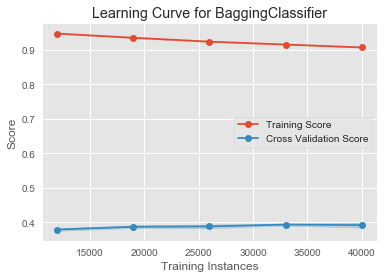

In [46]:
# Instantiate the classification model and visualizer

X = df_fires[feature_names]
y = df_fires['fire_intensity']
y = LabelEncoder().fit_transform(y)
#X = OneHotEncoder(categories="auto").fit_transform(X)
X = StandardScaler().fit_transform(X) 

model = BaggingClassifier()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

     

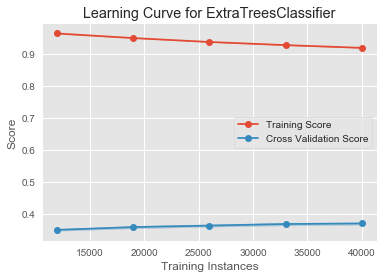

In [19]:
# Instantiate the classification model and visualizer
model = ExtraTreesClassifier(n_estimators=5)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

  

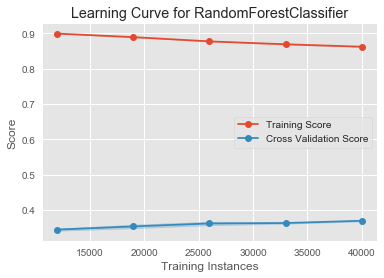

In [20]:
# Instantiate the classification model and visualizer
model = RandomForestClassifier(n_estimators=5)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure


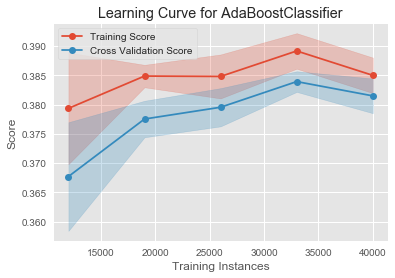

In [18]:
model = AdaBoostClassifier()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
#save to ML CVS files
df_fires.to_csv('data/fires2.csv',index = False)